In [21]:
import torch

import triton
import triton.language as tl
import matplotlib
import pandas as pd


In [45]:
# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `_matmul`.
@triton.jit
def leaky_relu(x):
    x = x + 1
    return tl.where(x >= 0, x, 0.01 * x)

# `triton.jit`'ed functions can be auto-tuned by using the `triton.autotune` decorator, which consumes:
#   - A list of `triton.Config` objects that define different configurations of
#       meta-parameters (e.g., `BLOCK_SIZE_M`) and compilation options (e.g., `num_warps`) to try
#   - An auto-tuning *key* whose change in values will trigger evaluation of all the
#       provided configs
@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
    ],
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel(
    # Pointers to matrices
    a_ptr, b_ptr, c_ptr,
    # Matrix dimensions
    M, N, K,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_am, stride_ak,
    stride_bk, stride_bn,
    stride_cm, stride_cn,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr,
    ACTIVATION: tl.constexpr,
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetics` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float16)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        # We accumulate along the K dimension.
        accumulator += tl.dot(a, b, out_dtype=tl.float16)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    if ACTIVATION == "leaky_relu":
        accumulator = leaky_relu(accumulator)
    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


In [46]:
def matmul(a, b, activation=""):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    assert b.is_contiguous(), "Matrix B must be contiguous"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=a.dtype)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (
        triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']),
    )
    matmul_kernel[grid](
        a, b, c,
        M, N, K,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1),
        ACTIVATION=activation
    )
    return c


In [47]:
def unit_test():
    torch.manual_seed(0)
    a = torch.randn((512, 512), device='cuda', dtype=torch.float16)
    b = torch.randn((512, 512), device='cuda', dtype=torch.float16)
    triton_output = matmul(a, b)
    torch_output = torch.matmul(a, b)
    print(f"triton_output={triton_output}")
    print(f"torch_output={torch_output}")
    if torch.allclose(triton_output, torch_output, atol=1e-2, rtol=0):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")

unit_test()


triton_output=tensor([[-21.6719,  -8.9531,   7.1094,  ..., -15.6328,   7.0469, -30.4844],
        [  8.7188,  16.2969,   4.4648,  ...,  -2.1113,   8.5469,  30.3438],
        [ -2.7812, -13.6016, -12.2578,  ..., -17.4688, -37.6562, -19.0625],
        ...,
        [ -2.7754, -15.6094, -27.3750,  ...,   9.8516, -20.9219, -24.5156],
        [ -9.5938,   2.1660,  17.7031,  ...,   3.6934, -30.4062,   8.1328],
        [  2.5254, -35.6250,  17.5938,  ...,   0.8433,   8.8359,   8.2344]],
       device='cuda:0', dtype=torch.float16)
torch_output=tensor([[-21.6875,  -8.9531,   7.0625,  ..., -15.6797,   7.0430, -30.4688],
        [  8.7578,  16.2969,   4.4766,  ...,  -2.0898,   8.5469,  30.3281],
        [ -2.7773, -13.6250, -12.2422,  ..., -17.4062, -37.6250, -19.0625],
        ...,
        [ -2.7598, -15.5859, -27.3281,  ...,   9.8359, -20.9219, -24.5000],
        [ -9.5859,   2.1406,  17.7188,  ...,   3.6484, -30.4531,   8.1172],
        [  2.5352, -35.6250,  17.5781,  ...,   0.8560,   8.8438, 

In [50]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['M', 'N', 'K'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            128 * i for i in range(2, 36)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['cublas', 'triton'],
        # Label name for the lines
        line_names=["cuBLAS", "Triton"],
        # Line styles
        styles=[('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
)
def benchmark(M, N, K, provider):
    a = torch.randn((M, K), device='cuda', dtype=torch.float16)
    b = torch.randn((K, N), device='cuda', dtype=torch.float16)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'cublas':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


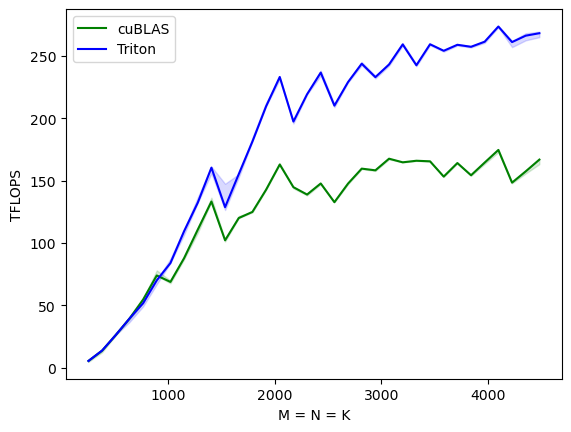

matmul-performance:
         M      cuBLAS      Triton
0    256.0    5.461333    5.461333
1    384.0   13.716838   13.824000
2    512.0   26.214401   26.214401
3    640.0   39.384616   39.384616
4    768.0   54.655507   51.757867
5    896.0   73.943582   70.082145
6   1024.0   68.794327   83.886082
7   1152.0   87.823057  109.451875
8   1280.0  110.702698  132.262364
9   1408.0  133.173158  160.346350
10  1536.0  102.138632  128.688872
11  1664.0  119.985488  155.153651
12  1792.0  124.882487  181.281035
13  1920.0  142.653333  209.454544
14  2048.0  162.885595  233.016881
15  2176.0  144.709382  197.290670
16  2304.0  138.807324  219.154788
17  2432.0  147.671301  236.522713
18  2560.0  132.663974  210.051289
19  2688.0  147.599436  228.943384
20  2816.0  159.567231  243.654800
21  2944.0  158.209619  232.878655
22  3072.0  167.523970  243.017615
23  3200.0  164.616993  259.109323
24  3328.0  165.878567  242.394943
25  3456.0  165.419996  259.233329
26  3584.0  153.177843  253.998290


In [51]:
benchmark.run(show_plots=True, print_data=True)
